## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df[(df['converted'] == 1 )].shape[0]/df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
#Calculate N times where group is treatment and page is not new_page

df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')].shape[0]


1965

f. Do any of the rows have missing values?

In [7]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

**No Missing Values**

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. 

a.Store your new dataframe in **df2**.

In [8]:
#Ignore all the mis-aligned rows, creating a new dataframe 
#by dropping them.
drop_index = df.query("landing_page == 'new_page' and group == 'control'").index
drop_index2 = df.query("landing_page == 'old_page' and group == 'treatment'").index
total_dropindex = drop_index.append(drop_index2)
df2= df.drop(total_dropindex)

In [9]:
df2.shape[0]

290585

In [10]:
# Double Check all of the correct rows were removed - this should be 0

df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
# less than N of rows by 1, indicating a duplicated ID
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
#ID 773192

dup_id = df2[df2.user_id.duplicated()].user_id
dup_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
dup = df2[(df2['user_id'] == 773192)]
dup

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
#Keeping the first original row, dropping the second duplicated
#one using its location
df2.drop(labels=2893, axis = 0, inplace= True)

df2.duplicated().sum()

0

In [15]:
# Making sure it returns only 1 user_id
dup = df2[(df2['user_id'] == 773192)]
print (dup)

      user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0


In [16]:
# Making sure now the N of rows matches the N of unique users
df2.shape

(290584, 5)

`4.`
a. What is the probability of an individual converting regardless of the page they receive (P_pop)?

In [17]:
p_pop = df2[(df2['converted'] == 1 )].shape[0]/df2.shape[0]
p_pop

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted (P_cont)?

In [18]:
p_cont = (df2.query("group == 'control' and converted == 1")).shape[0]/df2.query("group == 'control'").shape[0]
p_cont

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted (P_ttt)?

In [19]:
p_ttt = (df2.query("group == 'treatment' & converted == 1")).shape[0]/df2.query("group == 'treatment'").shape[0]
p_ttt

0.11880806551510564

In [20]:
#Calculating the observed difference between them
obs_diff = p_ttt - p_cont
obs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page(P_new)?

In [21]:
p_new_page= (df2.query("landing_page == 'new_page'")).shape[0]/df2.shape[0]
p_new_page

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Considering the above results:
NO,there isn't enough evidence to say that new treatment page leads to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_0$ : $p_{new}$** <= **$p_{old}$** --->   **$p_{new}$**-**$p_{old}$** <= 0                                   
  $H_1$ : **$p_{new}$** > **$p_{old}$**  --->   **$p_{new}$**-**$p_{old}$** > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [22]:
p_new = (df2.query("converted == 1")).shape[0]/df2.shape[0]
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [23]:
p_old = (df2.query("converted == 1")).shape[0]/df2.shape[0]
p_old 

0.11959708724499628

c. What is $n_{new}$?

In [24]:
n_new = df2.query("landing_page == 'new_page'").shape[0]
n_new

145310

d. What is $n_{old}$?

In [25]:
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
#np.random.choice to generate a random sample from a given 1-D array

new_page_converted = np.random.choice([0,1],n_new, p=[1-p_new, p_new])
new_page_converted.mean()


0.12055605257724863

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
old_page_converted = np.random.choice([0,1],n_old, p=(1-p_old, p_old))
old_page_converted.mean()


0.11973236780153365

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
new_page_converted.mean() - old_page_converted.mean()

0.0008236847757149834

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [29]:
#Chose to do it in binomial way, as it is much faster than bootstraping

p_diff = []

New_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
Old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old
p_diff = (New_page_converted) - (Old_page_converted)

p_diffs = np.array(p_diff)

#### This is the bootstrapping random.choice method (marked down next cell)
It brings out a similar output
but much slower than numpy binomial function 
Feel free to markdown the binomial and use the bootstrapping cell as code.


p_diff=[]

for _ in range(10000):
    New_page_converted = np.random.choice([0,1],size = n_new,p=(1-p_new,p_new))
    Old_page_converted = np.random.choice([0,1],size = n_old,p=(1-p_old,p_old))
    Diff = new_page_converted.sum()/n_new - old_page_converted.sum()/n_old
    p_diff.append(Diff)
    
p_diffs=np.array(p_diff)

In [30]:
#p_diffs=np.array(p_diffs)
p_diffs.mean()

-2.968753919246449e-06

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

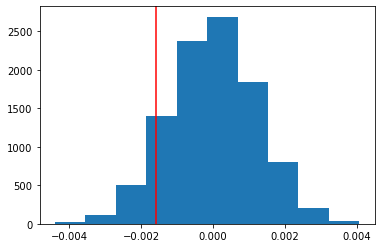

In [31]:
plt.hist(p_diffs);
plt.axvline(obs_diff,color='r');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
(p_diffs > obs_diff).mean()

0.9007

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**This means that P-Value is around 0.9, this is much higher than our type 1 error rate 0.05, which means we failed to reject the null hypothesis ($P_{new}$ - $P_{old}$ <= 0).. In other words, this data indicates that the new page has no significant effect, so the old page is as good or even better.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm

convert_old  =  (df2.query("landing_page == 'old_page' and converted == 1")).shape[0]
convert_new  =  (df2.query("landing_page == 'new_page' and converted == 1")).shape[0]
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [34]:
import statsmodels.api as sm

count_array = np.array([convert_new, convert_old])
nobs_array =  np.array([n_new, n_old])
z_score, p_value = sm.stats.proportions_ztest(count_array, nobs_array, alternative = 'larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**1. Z-score is 1.3 which is less than Z-0.05 (1.645), this means we fail to reject our Null Hypothesis (Rt tailed test).                                                     2. P-value again is 0.9 the same as we computed in the above portions, which agrees with the above findings that we fail to reject our Null Hypothesis.
Again, these are saying that we should keep using the old page, as the new one is not getting more conversion rates than the old.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
#adding intercept & dummies
df2['intercept']= 1
df2[['old_page', 'ab_page']]= pd.get_dummies(df2['group'])

#dropping 'old_page', we only need ab_page
df2 = df2.drop('old_page', axis=1)

#having a look at the outcome
df2.head()



,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [36]:
#statsmodels for logistic regression
logit_mod =sm.Logit(df2['converted'],df2[['intercept', 'ab_page']])

results = logit_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 09 Apr 2022   Pseudo R-squ.:               8.077e-06
Time:                        05:45:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

**Here H0 is Pnew = Pold and H1 is Pnew != Pold . So, this is a two sided test , comparing to the right tailed test we have been using previously. That's why although P-value is 0.19 (still larger than error calue 0.05) so it also fails to reject the Null, but the P-value is different than previously calculated one in the right tailed test**


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**It's a good idea to add more factors because we might be interpreting falsely that the new page isn't making significant difference, when maybe there are other factors leading to this result, for example; if the experiment is made for a period of time that isn't long enough for old users to adapt and make the change. on the contrary, adding too many terms and factors may lead to more errors and problems calculating and interpreting the results e.g multicollinearity (where variables are related to one another)**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  

In [38]:
#reading the data and having a look
df_countries = pd.read_csv('./countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [39]:
#joining two dataframes into df_merged
df_merged = df2.set_index('user_id').join(df_countries.set_index('user_id'), how='inner')
df_merged.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country
user_id,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [40]:
#what are the countries in this column?
df_merged.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [41]:
#Create theintercept & necessary dummy variables
df_merged['intercept'] = 1
df_merged[['CA', 'UK','US']]= pd.get_dummies(df_merged['country'])

#drop one of the dummies "CA"
df_merged = df_merged.drop('CA', axis=1)

#have a look
df_merged.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US
user_id,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1


In [42]:
#Fitting the model and summarize
logit_mod_2=sm.Logit(df_merged['converted'],df_merged[['intercept','ab_page', 'UK', 'US']])
results_2 = logit_mod_2.fit()
results_2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 09 Apr 2022   Pseudo R-squ.:               2.323e-05
Time:                        05:45:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

**Adding the country where the user lives has no significance on converting prediction.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [43]:
### Fit Your Linear Model
df_merged['US_Page'] = df_merged['ab_page'] * df_merged['US']
df_merged['UK_Page'] = df_merged['ab_page'] * df_merged ['UK']


In [44]:
#Obtain the Results
lm=sm.OLS(df_merged['converted'],df_merged[['intercept','ab_page','UK','US', 'UK_Page', 'US_Page']])
results_3 = lm.fit()
results_3.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.466
Date:                Sat, 09 Apr 2022   Prob (F-statistic):              0.197
Time:                        05:45:28   Log-Likelihood:                -85265.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290578   BIC:                         1.706e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1188      0.004     31.057      0.000       0.111       0.126
ab_page       -0.0069      0.005     -1.277      0.202      -0.017       0.004
UK             0.0012      0.004      0.296      0.767      -0.007       0.009
US             0.0018      0.004      0.467      0.641      -0.006       0.010
UK_Page        0.0080      0.006      1.360      0.174      -0.004       0.020
US_Page        0.0047      0.006      0.845      0.398      -0.006       0.016
==============================================================================
Omnibus:                   125549.436   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414285.945
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         26.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**P_values for all variables are higher than 0.05 error rate, which means there's no statistical significance, so adding them didn't affect our previous results( failure to reject the null, as new page hasn't proven to be better )**

### For how long has this experiment been running ?

In [45]:
#earliest and latest data results
df2.timestamp.min(),df2.timestamp.max()

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

<a id='conclusions'></a>
## Conclusions
#### Statistics:
1. P-value in all our tests was more than type 1 error rate (5%) --> Fail to reject Null Hypothesis
2. P-values for our tested variables (page & country) are high --> They are not stastically significant in prediction of conversion.
3. The experiment has been running for about 3 weeks.
#### Practically:
1. Given the above data, the new page hasn't proven to be able to increase number of users who convert.
2. Based solely on the above data, we should keep the old page.
3. Although 3 weeks seems to be a good experimental duration, these users may need more time to adapt to the new page.





### Resources :
1. https://numpy.org/doc/stable/reference/random/generated/numpy.random.binomial.html
2. https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
3. https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples
4. https://statistics.laerd.com/statistical-guides/standard-score-2.php
5. Udacity Classroom notebooks and quizzes
6. Eg FWD Walkthrough Sessions.